<a href="https://www.kaggle.com/code/luisprezsala/batman?scriptVersionId=91150441" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
######## Install Libraries ########
!pip install squarify
!pip install plotly

In [2]:
######## Loading Files ########
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
from wordcloud import WordCloud
import spacy
import plotly.express as px

DATASET_PATH = '../input/sanfranciscopolicedepartmentincidentreports/'
INCIDENTS_FILE = 'Police_Department_Incident_Reports__2018_to_Present.csv'
SCHOOLS_FILE  = 'Schools.csv'
COLLEGES_FILE = 'Schools_College.csv' 

incidents_df = pd.read_csv(DATASET_PATH + INCIDENTS_FILE)
schools_df   = pd.read_csv(DATASET_PATH + SCHOOLS_FILE)
colleges_df  = pd.read_csv(DATASET_PATH + COLLEGES_FILE)

# Serie temporal: Evolución del número de incidentes por año y mes

<AxesSubplot:title={'center':'Número de incidentes por Mes/Año'}, xlabel='Mes', ylabel='Número de incidentes'>

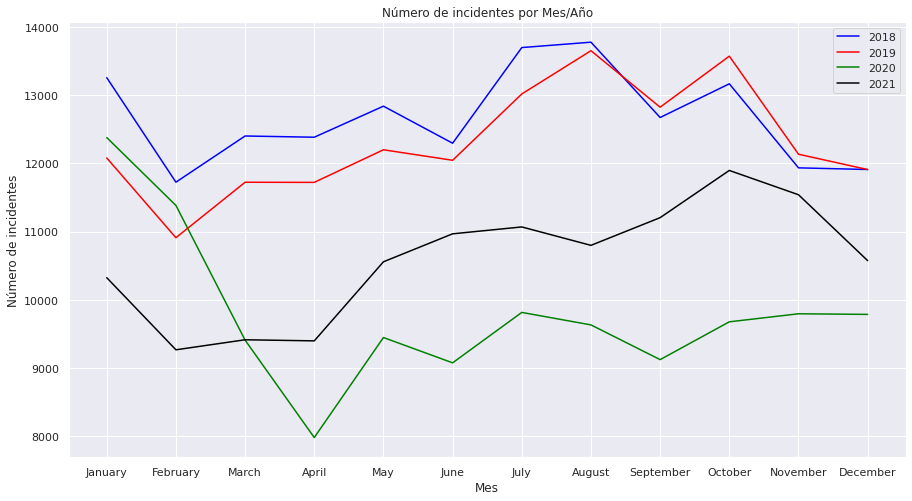

In [3]:
incidents_df['Incident Datetime'] = pd.to_datetime(incidents_df['Incident Datetime'])
incidents_df['Report Datetime'] = pd.to_datetime(incidents_df['Report Datetime'])
incidents_df = incidents_df.sort_values('Incident Datetime')

incidents_2018 = incidents_df[incidents_df['Incident Datetime'].between('2018-01-01', '2018-12-31')]
incidents_2019 = incidents_df[incidents_df['Incident Datetime'].between('2019-01-01', '2019-12-31')]
incidents_2020 = incidents_df[incidents_df['Incident Datetime'].between('2020-01-01', '2020-12-31')]
incidents_2021 = incidents_df[incidents_df['Incident Datetime'].between('2021-01-01', '2021-12-31')]
incidents_2022 = incidents_df[incidents_df['Incident Datetime'].between('2022-01-01', '2022-12-31')]

# incidents_2022.groupby(by=[incidents_2022.index.month,incidents_2022.index.year])
monthly_2018 = incidents_2018.groupby(incidents_2018['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2019 = incidents_2019.groupby(incidents_2019['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2020 = incidents_2020.groupby(incidents_2020['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2021 = incidents_2021.groupby(incidents_2021['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2022 = incidents_2022.groupby(incidents_2022['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()

months_sorted = sorted(monthly_2021.keys(), key=lambda day: datetime.strptime(day, "%B"))

test_2018 = [] 
test_2019 = []
test_2020 = []
test_2021 = []
test_2022 = []

for month in months_sorted:
    test_2018.append(monthly_2018[month])
    test_2019.append(monthly_2019[month])
    test_2020.append(monthly_2020[month])
    test_2021.append(monthly_2021[month])
#     if monthly_2022[month]: test_2022.append(monthly_2022[month])

sns.set_theme(style="darkgrid")

sns.set(rc={'figure.figsize':(15,8)})

plt.title("Número de incidentes por Mes/Año")
plt.xlabel("Mes")
plt.ylabel("Número de incidentes")

sns.lineplot(x=months_sorted, y=test_2018, color='blue',  legend='brief', label=str('2018'))
sns.lineplot(x=months_sorted, y=test_2019, color='red',   legend='brief', label=str('2019'))
sns.lineplot(x=months_sorted, y=test_2020, color='green', legend='brief', label=str('2020'))
sns.lineplot(x=months_sorted, y=test_2021, color='black', legend='brief', label=str('2021'))

# Comparación incidentes época COVID-19/No-COVID-19

Observando la serie temporal anterior apreciamos que el número de incidentes de la época del confinamiento debido al COVID-19 entre los meses TAL Y TAL del año 2020 y los del año anterior varían considerablemente como es lógico. Analizaremos qué tipos de incidente ocurrieron durante esta etapa de confinamiento y los compararemos con los del año anterior.

,Incident,Not COVID incident count,Not COVID Percentage,COVID incident count,COVID Percentage,Difference (ABS)
0,Larceny Theft,7052,0.300290,4386,0.251664,0.048626
5,Burglary,1025,0.043647,1292,0.074134,0.030487
6,Motor Vehicle Theft,860,0.036621,1047,0.060076,0.023455
10,Lost Property,1016,0.043263,380,0.021804,0.021460
2,Malicious Mischief,1458,0.062085,1367,0.078437,0.016352


<AxesSubplot:xlabel='COVID incident count', ylabel='Incident'>

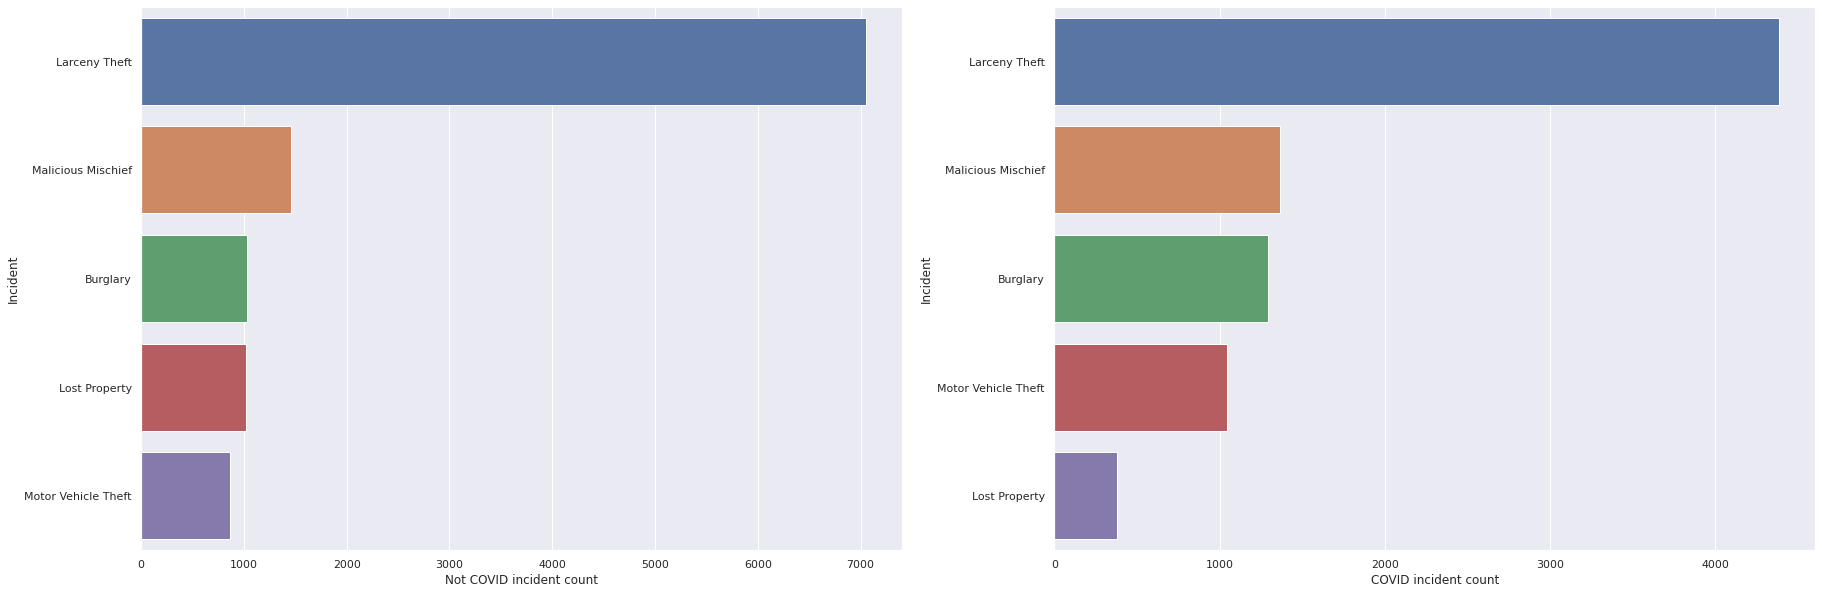

In [4]:
############ COVID ############
not_covid_data_frame = incidents_2019[incidents_2019['Incident Datetime'].between('2019-03-01', '2019-05-01')]
covid_data_frame = incidents_2020[incidents_2020['Incident Datetime'].between('2020-03-01', '2020-05-01')]

not_covid_order = pd.Categorical(not_covid_data_frame['Incident Category'].value_counts().index)
covid_order = pd.Categorical(covid_data_frame['Incident Category'].value_counts().index)

difference_dataframe = pd.DataFrame(columns=['Incident', 'Not COVID incident count','Not COVID Percentage',
                                              'COVID incident count', 'COVID Percentage', 'Difference (ABS)'])

for incident in incidents_df['Incident Category'].value_counts().iteritems():
    not_covid_incident_count = (not_covid_data_frame['Incident Category'] == incident[0]).sum()
    covid_incident_count     = (covid_data_frame['Incident Category'] == incident[0]).sum()
    
    not_covid_percentage = not_covid_incident_count / len(not_covid_data_frame)
    covid_percentage     = covid_incident_count / len(covid_data_frame)

    difference_dataframe = difference_dataframe.append({'Incident': incident[0],
                                                        'Not COVID incident count': not_covid_incident_count,
                                                        'Not COVID Percentage': not_covid_percentage,
                                                        'COVID incident count': covid_incident_count,
                                                        'COVID Percentage': covid_percentage,
                                                        'Difference (ABS)': np.abs(covid_percentage - not_covid_percentage)},
                                                       ignore_index=True)

difference_dataframe = difference_dataframe.sort_values('Difference (ABS)', ascending = False)[:5]
not_covid_display = difference_dataframe.sort_values('Not COVID incident count', ascending = False)
covid_display     = difference_dataframe.sort_values('COVID incident count', ascending = False)

display(difference_dataframe)

sns.set(rc={'figure.figsize':(30,10)})
fig, ax =plt.subplots(1,2)
sns.barplot(data=not_covid_display, x='Not COVID incident count', y="Incident", ax=ax[0])
sns.barplot(data=covid_display, x='COVID incident count', y="Incident", ax=ax[1])

# Comparación incidentes Febrero/Octubre 2021

Debido a que en la gráfica temporal mostrada anteriormente se aprecia que en el año 2021 se producen muchos más incidentes en octubre que en febrero, analizaremos qué tipo de incidentes se cometen en ambos periodos.

<AxesSubplot:xlabel='count', ylabel='Incident Category'>

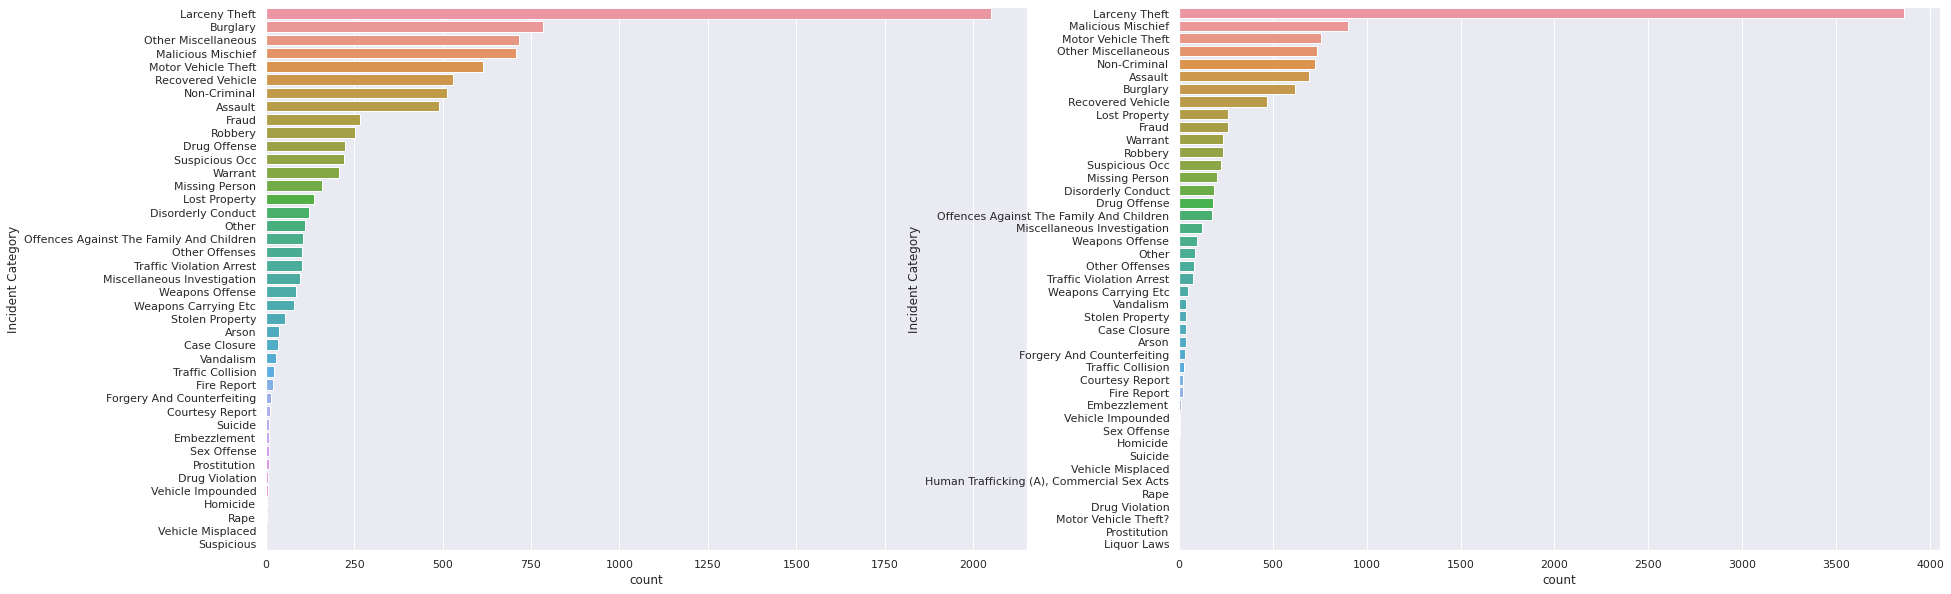

In [5]:
############ SUMMER ############
october_epoch = incidents_2021[incidents_2021['Incident Datetime'].between('2021-02-01', '2021-02-28')]
february_epoch = incidents_2021[incidents_2021['Incident Datetime'].between('2021-10-01', '2021-10-31')]

october_order = pd.Categorical(october_epoch['Incident Category'].value_counts().index)
february_order = pd.Categorical(february_epoch['Incident Category'].value_counts().index)

fig, ax =plt.subplots(1,2)
sns.countplot(data=october_epoch, y="Incident Category", order = october_order, ax=ax[0])
sns.countplot(data=february_epoch, y="Incident Category", order = february_order, ax=ax[1])

# print(incidents_2021['Incident Datetime'].count())
# incidents_2021['Incident Datetime'].plot()
# incidents_2021.groupby(['Incident Datetime']).mean()

# Incidentes más frecuentes Día/Noche
Analizaremos qué incidentes son más frecuentes en las horas diurnas y nocturnas 

In [6]:
daily_data_frame   = incidents_df[incidents_df['Incident Datetime'].dt.strftime("%H:%M:%S").between('07:00:00', '18:00:00')]
nightly_data_frame = incidents_df[incidents_df['Incident Datetime'].dt.strftime("%H:%M:%S").between('18:00:01', '23:59:59')]
nightly_data_frame = nightly_data_frame.append(incidents_df[incidents_df['Incident Datetime'].dt.strftime("%H:%M:%S").between('00:00:00', '06:59:59')])

daily_data_frame_order   = pd.Categorical(daily_data_frame['Incident Category'].value_counts().index)
nightly_data_frame_order = pd.Categorical(nightly_data_frame['Incident Category'].value_counts().index)

,Incident,Daily Percentage,Nightly Percentage,Difference (ABS)
5,Burglary,0.041951,0.076347,0.034397
2,Malicious Mischief,0.056771,0.081255,0.024484
3,Non-Criminal,0.068151,0.051204,0.016947
11,Drug Offense,0.030201,0.014517,0.015683
8,Warrant,0.035021,0.025241,0.009780
9,Fraud,0.033626,0.025414,0.008212
4,Assault,0.056530,0.064659,0.008130
7,Recovered Vehicle,0.040993,0.033365,0.007628
0,Larceny Theft,0.306641,0.299409,0.007232
10,Lost Property,0.032738,0.025850,0.006888


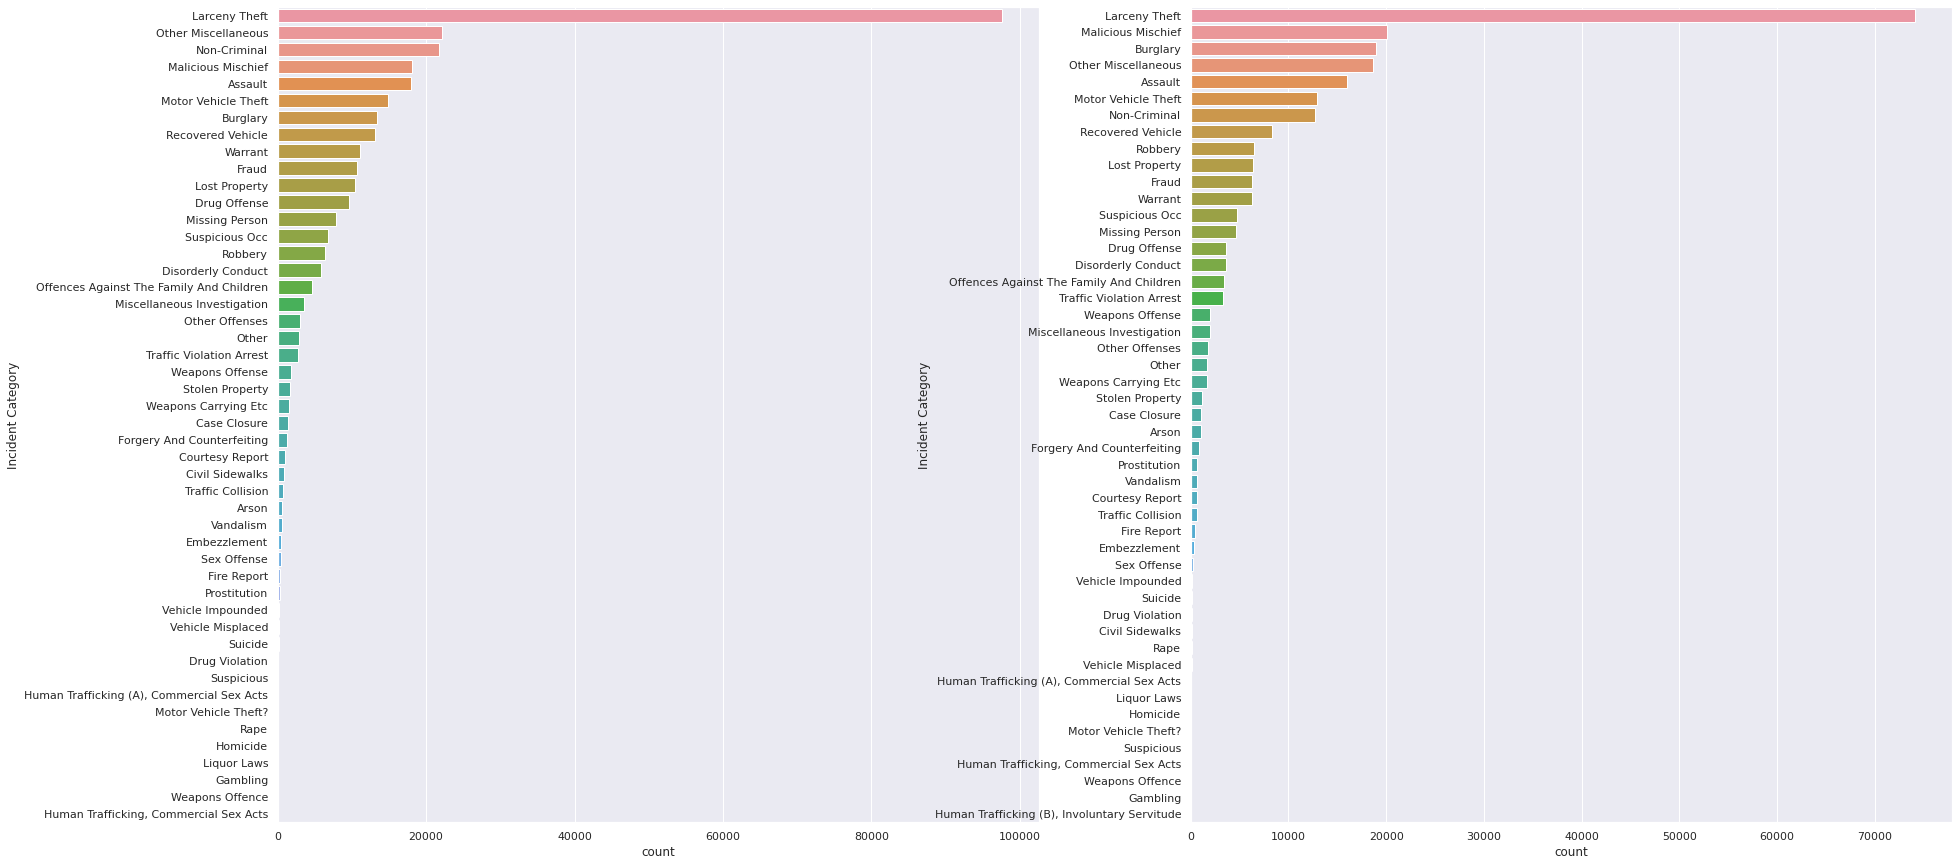

In [7]:
sns.set(rc={'figure.figsize':(30,15)})

fig, ax =plt.subplots(1,2)
sns.countplot(data=daily_data_frame, y="Incident Category", order = daily_data_frame_order, ax=ax[0])
sns.countplot(data=nightly_data_frame, y="Incident Category", order = nightly_data_frame_order, ax=ax[1])

difference_dataframe = pd.DataFrame(columns=['Incident', 'Daily Percentage', 'Nightly Percentage', 'Difference (ABS)'])

for incident in incidents_df['Incident Category'].value_counts().iteritems():
    day_percentage   = (daily_data_frame['Incident Category']   == incident[0]).sum() / len(daily_data_frame)
    night_percentage = (nightly_data_frame['Incident Category'] == incident[0]).sum() / len(nightly_data_frame)

    difference_dataframe = difference_dataframe.append({'Incident': incident[0],
                                                        'Daily Percentage': day_percentage,
                                                        'Nightly Percentage': night_percentage,
                                                        'Difference (ABS)': np.abs(day_percentage - night_percentage)},ignore_index=True)


difference_dataframe.sort_values('Difference (ABS)', ascending = False)

Podemos observar que se producen más incidentes por el día que por la noche

Más allanamiento por la noche

Más robos por la noche

Más drogas por el día

# Revisaremos la correlación de los datasets utilizando matrices de correlación:
1. Police Departmen Incidents
2. Schools College
3. Schools

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566245 entries, 216240 to 12211
Data columns (total 34 columns):
 #   Column                                                Non-Null Count   Dtype         
---  ------                                                --------------   -----         
 0   Incident Datetime                                     566245 non-null  datetime64[ns]
 1   Incident Date                                         566245 non-null  object        
 2   Incident Time                                         566245 non-null  object        
 3   Incident Year                                         566245 non-null  int64         
 4   Incident Day of Week                                  566245 non-null  object        
 5   Report Datetime                                       566245 non-null  datetime64[ns]
 6   Row ID                                                566245 non-null  int64         
 7   Incident ID                                           566245 

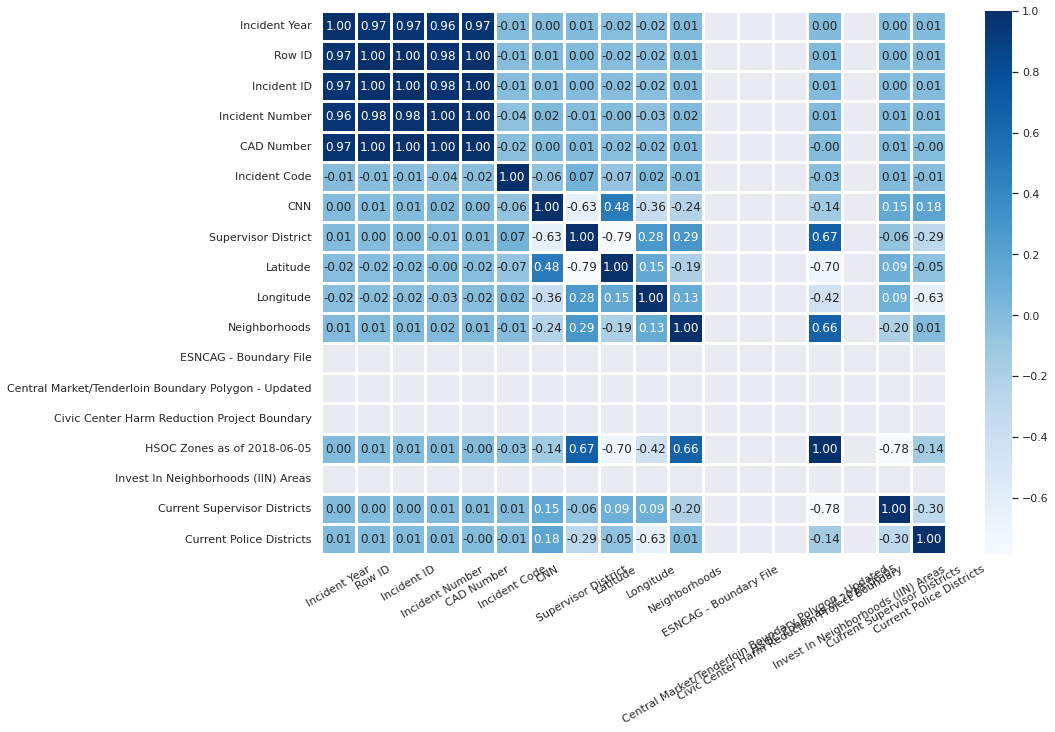

In [8]:
print(incidents_df.info())
#print(schools_df.info())
#print(colleges_df.info())


incidents = incidents_df.copy()#[['Platform', 'Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].groupby(by=['Platform']).sum()
#platform_sales = platform_sales.sort_values(by='Global_Sales', ascending=False)[:10]  # Nos quedamos con el Top 10
#for col in ['Report Type Description', 'Incident Category', 'Incident Category', 'Incident Subcategory', 'Incident Description', 'Resolution', 'Police District']:
#    incidents[col] = incidents[col].astype('category')

incidents.drop(columns = ['Incident Datetime','Incident Date', 'Incident Time', 'Incident Day of Week', 'Report Datetime', 'Report Type Code', 'Report Type Description', 'Filed Online', 'Incident Category', 'Incident Subcategory', 'Incident Description', 'Resolution', 'Intersection', 'Police District', 'Analysis Neighborhood', 'Point'], axis = 1, inplace=True)
plt.figure(figsize=(14, 10))
sns.heatmap(incidents.corr('spearman'), annot=True, fmt='.2f', linewidth=3, cmap='Blues')
plt.yticks(rotation=0)
plt.xticks(rotation=30)
plt.show()

# Diagrama de Arbol de las "Categorías de Crimen" mas frecuentes

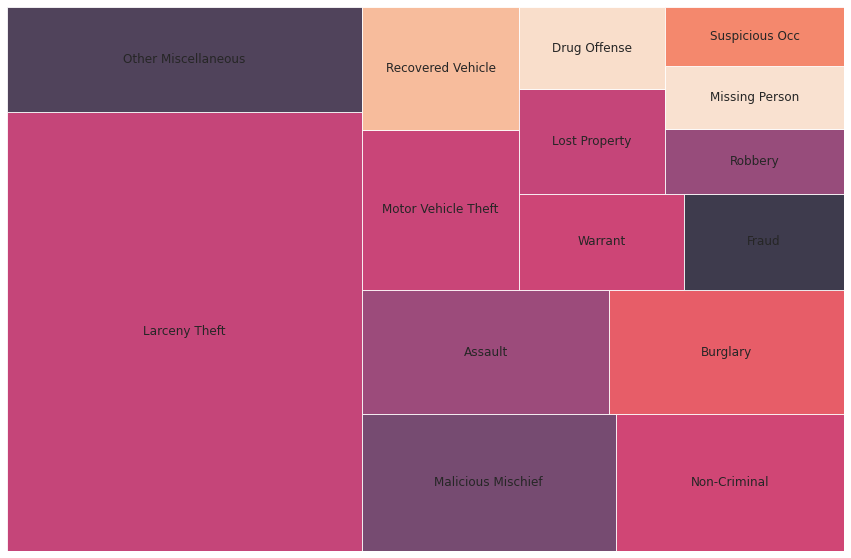

In [9]:
incidents_category = incidents_df['Incident Category'].value_counts()[:15].copy()

plt.figure(figsize=(15,10))
squarify.plot(sizes=incidents_category.values, label=incidents_category.index, alpha=.8)
plt.axis('off')
plt.show()

# Diagrama de Arbol de las "Subcategorías de Crimen" mas frecuentes

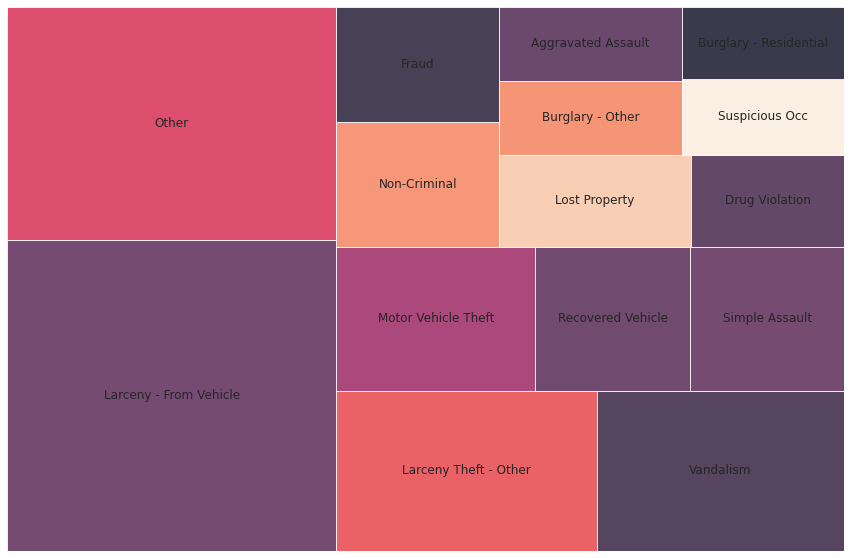

In [10]:
incidents_category = incidents_df['Incident Subcategory'].value_counts()[:15].copy()

plt.figure(figsize=(15,10))
squarify.plot(sizes=incidents_category.values, label=incidents_category.index, alpha=.8)
plt.axis('off')
plt.show()

# Nube de palabras para análizar las descripciones de los incidentes reportados

In [11]:
nlp = spacy.load('en_core_web_sm') # Utilizamo el SM porque no se puede cargar el Medium

list_words = [x.split() for x in incidents_df['Incident Description'].values]  # Obtenemos todas las palabras individuales para cada nombre
list_words = ' '.join([word for sublist in list_words for word in sublist])  # Las juntamos todas en un único texto
list_words = list_words[:1000000]

corpus = nlp(list_words)  # Procesamos las palabras con SpaCy
tokens = [w.lower_ for w in corpus if (not w.is_space and not w.is_punct)]  # Eliminamos espacios en blanco y signos de puntuación
corpus = ' '.join(tokens)  # Ya tenemos la lista de palabras limpia

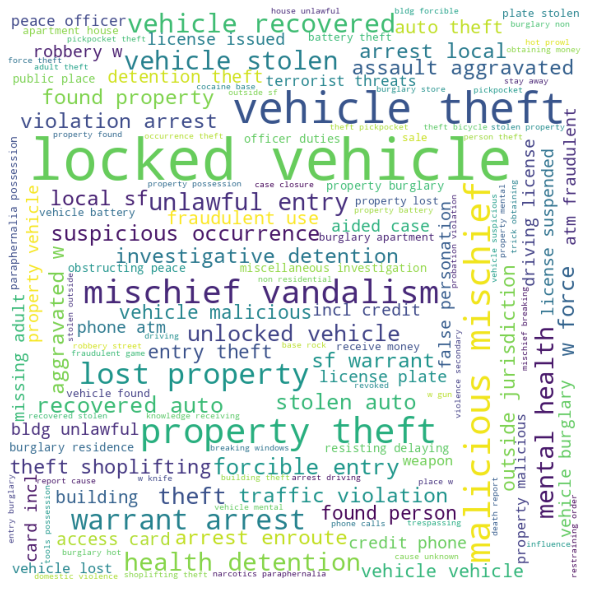

In [12]:
wordcloud = WordCloud(width=700, height=700, background_color='white', min_font_size=10).generate(corpus)
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad=0) 
plt.show()

## Calculamos el tiempo promedio de reporte por categoría de incidente

In [13]:
# sacar la proporcion de incidentes resueltos y no resueltos.
# Calcular el tiempo promedio de reporte de un incidente y ver si tiene algún sentido.
# obtenemos la diferencia de tiempo entre la fecha de reporte y la fecha del incidente.
incidents_df['Difference Date'] = abs(incidents_df['Incident Datetime'] - incidents_df['Report Datetime'])

## Tiempo promedio de reporte
Este es el top 15 de las categorías de incidentes que más demoran en reportarse.

Con este análisis tenemos que el tráfico de humanos ha demorado más en reportarse. Hay que considerar que en el dataset solo se cuenta con un registro.

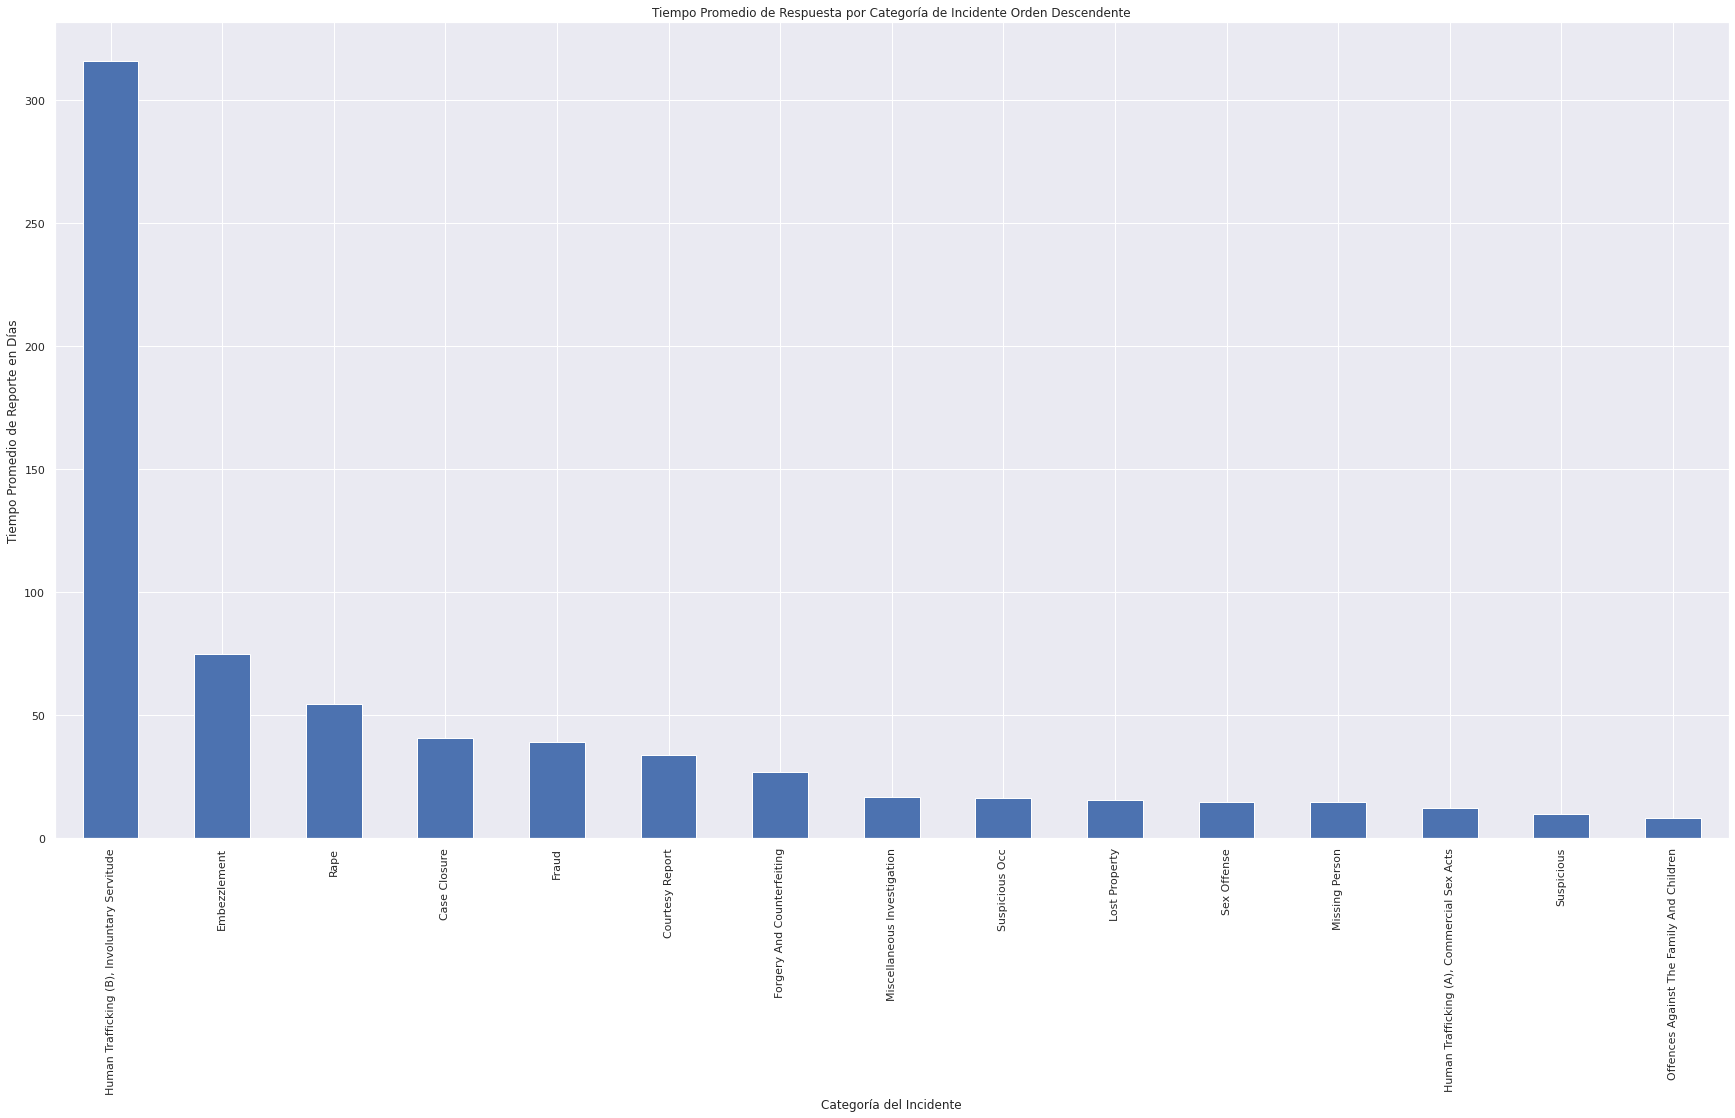

In [14]:


df_Test = incidents_df.groupby('Incident Category')['Difference Date'].mean().sort_values(ascending = False)[:15].astype('timedelta64[h]') / 24
df_Test.plot(kind = 'bar', title = 'Tiempo Promedio de Respuesta por Categoría de Incidente Orden Descendente', rot = 90)

plt.xlabel('Categoría del Incidente')
plt.ylabel('Tiempo Promedio de Reporte en Días')
plt.show()

Este es el top 15 de las categorías de incidentes que más rápido se reportan.

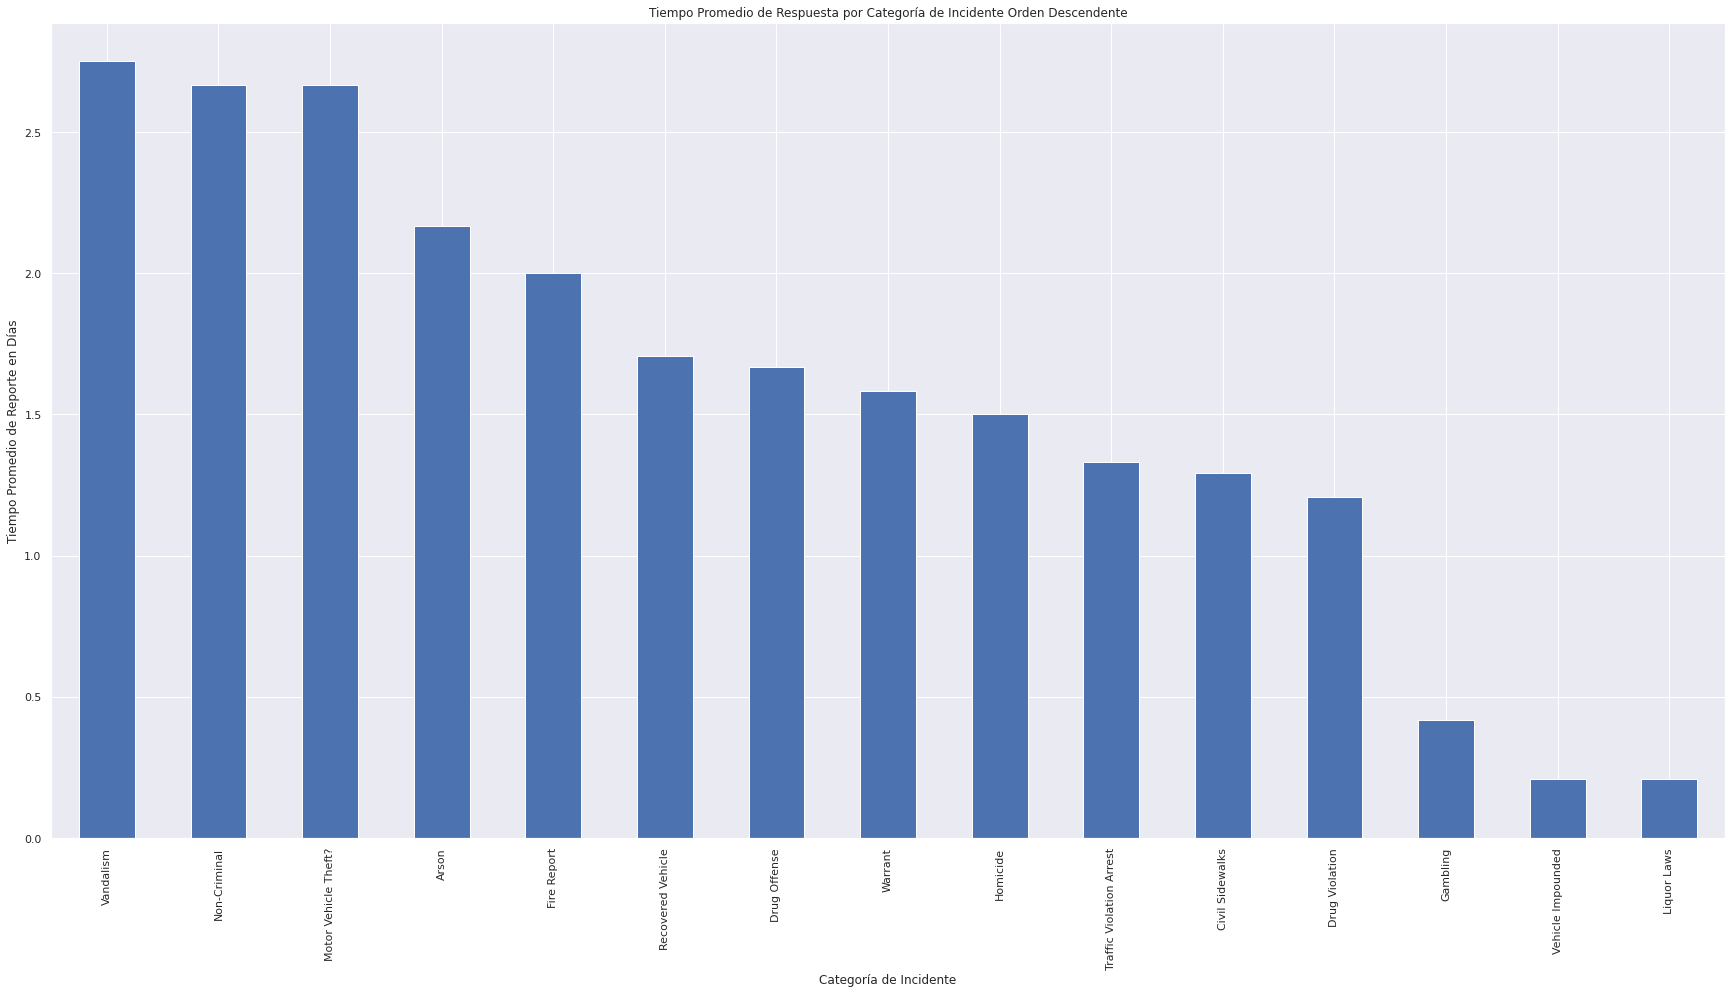

In [15]:
df_Test = incidents_df.groupby('Incident Category')['Difference Date'].mean().sort_values()[:15].sort_values(ascending = False).astype('timedelta64[h]') / 24
df_Test.plot(kind = 'bar', title = 'Tiempo Promedio de Respuesta por Categoría de Incidente Orden Descendente', rot = 90)

plt.xlabel('Categoría de Incidente')
plt.ylabel('Tiempo Promedio de Reporte en Días')
plt.show()

# Plots de crímenes por código ID

In [16]:
import pandas as pd
import folium
from folium import plugins

df_og = pd.read_csv("../input/sanfranciscopolicedepartmentincidentreports/Police_Department_Incident_Reports__2018_to_Present.csv")
df=df_og.groupby(['Police District', 'Incident Code'], as_index=False).size()
df['Police District'] = df['Police District'].str.upper()
names_df = df['Police District'].unique()
id_crimes = df['Incident Code'].unique()

####### all crimes id #######
for id_name in id_crimes:
    df_counts = pd.DataFrame()
    
    for it in names_df:
        df_counts = df_counts.append(df.loc[(df['Police District'] == it) & (df['Incident Code'] == id_name)].nlargest(1, columns=['size']))
    
    # df_counts = df_counts.drop(index=3021)
    
    sf_map = folium.Map()
    sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12)
    folium.TileLayer('stamenterrain').add_to(sf_map)
    sf_geo = r'../input/sfgeojson/san-francisco.geojson'
    
    sf_map.choropleth(
        geo_data=sf_geo,
        data=df_counts,
        columns=['Police District', 'size'],
        key_on='feature.properties.DISTRICT',
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        line_opacity=0.4,
        legend_name='Number of crimes',
        name=id_name
    )
    
    loc = 'Incident Code: '+str(id_name)
    title_html = '''
                 <h3 align="center" style="font-size:16px"><b>{}</b></h3>
                 '''.format(loc)   
    sf_map.get_root().html.add_child(folium.Element(title_html))
    
    sf_map.save(str(id_name)+"_"+"SFmap.html")

/opt/conda/lib/python3.7/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Crímenes más cometidos con código ID por distrito

In [17]:
####### top crimes id by district #######

# bayview, central, ingleside,  mission, northern, parkside, richmond, southern, taraval, tenderloin 
lat_ = [37.7311, 37.7782, 37.7235,  37.7599300,  37.8011749, 37.7392,  37.7803, 37.77217, 37.7631, 37.78365]
long_ = [-122.3849, -122.4011, -122.4349, -122.4191376, -122.4090021, -122.484, -122.4715, -122.38909, -122.4546, -122.41295]

df_counts = pd.DataFrame()

for it in names_df:
    df_counts = df_counts.append(df.loc[df['Police District'] == it].nlargest(1, columns=['size']))

df_counts = df_counts.drop(index=3021)

sf_map = folium.Map()
sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12)
folium.TileLayer('stamenterrain').add_to(sf_map)
sf_geo = r'../input/sfgeojson/san-francisco.geojson'

sf_map.choropleth(
    geo_data=sf_geo,
    data=df_counts,
    columns=['Police District', 'size'],
    key_on='feature.properties.DISTRICT',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.4,
    legend_name='Number of crimes',
    name='Most common crimes by district'
)

loc = 'Top Crimes by District'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
sf_map.get_root().html.add_child(folium.Element(title_html))

for lat, lon, value in zip(lat_,long_,df_counts['Incident Code']):
    folium.Marker(location=[lat,lon],
                  icon=folium.DivIcon(html=f"""<div style="">{value}</div>""")
                  ).add_to(sf_map)

# for lat, lon, value in zip(lat_,long_,df_counts['Incident Code']):
#     folium.Marker(location=[lat,lon],
#                   popup=value
#                   ).add_to(sf_map)

# locations = list(zip(lat_, long_))
# cluster = plugins.MarkerCluster(locations=locations,                     
#                popups=df_counts["Incident Code"].tolist())  
# sf_map.add_child(cluster)

sf_map.save("mc_"+"SFmap.html")

In [18]:
from IPython.display import IFrame
IFrame(src='6378_SFmap.html', width=900, height=600)